<a href="https://colab.research.google.com/github/3-Ada/image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

## Step 0: import dataset from Kaggle

The dataset "Intel Image Classification" is used for this project

Here is the link for it: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

To import the chosen dataset from Kaggle, we need to perform the following steps:

1. Import the library for working with files in Google Colab.

In [1]:
from google.colab import files # library for working with files

2. Next, we need upload the kaggle.json file from local machine to Google Colab. This file is used to authenticate access to the Kaggle platform and allows to interact with Kaggle's datasets.
3. After uploading the file, we need install Kaggle API client, which allows to interact with Kaggle within Colab.

In [2]:
files.upload() # upload kaggle.json from pc

!pip install -q kaggle # install kaggle API client

Saving kaggle.json to kaggle.json


4. The folder with name ".kaggle" is created in the root directory to store kaggle.json
5. kaggle.json is moved to the created folder.
6. Set the permissions of file to ensure its security.

In [3]:
! mkdir ~/.kaggle # create folder with name .kaggle
! cp kaggle.json ~/.kaggle/ # move kaggle.json to created directory
! chmod 600 /root/.kaggle/kaggle.json # change permissions to more secure

7. Download the dataset from Kaggle

In [4]:
! kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:02<00:00, 179MB/s]
100% 346M/346M [00:02<00:00, 161MB/s]


8. The unzip command may produce a lengthy output. To keep the cell output clean, we can use the magic command %%capture, which suppresses the output of the cell.
9. For storing images, director "image_files" is created.
10. Unzip the "intel-image-classification.zip" file into the "/content/image_files/" directory

In [5]:
# for not showing output
%%capture
! mkdir /content/image_files
! unzip intel-image-classification.zip -d /content/image_files

## Step 1: explore the dataset

First, we need explore the dataset.

Let's import all the necessary libraries for this step.

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

Then let's create dataframe which contain information about each image, such as file name, label and category.

For doing this, we iterate over the items in the labels. After we traverse though folder with name of given label, and add information about each image to created dataframe.

In [7]:
root_dir = "/content/image_files/seg_train/seg_train/"
sub_folders = os.listdir(root_dir)
labels = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4,
          'street': 5}

data = []

for s, l in labels.items():
  for r, d, f in os.walk(root_dir + s):
      for file in f:
          if ".jpg" in file:
              data.append((os.path.join(s,file), l, s))

df_images_info = pd.DataFrame(data, columns=['file_name', 'label', 'category'])

In [8]:
df_images_info.head()

,file_name,label,category
0,buildings/10362.jpg,0,buildings
1,buildings/1859.jpg,0,buildings
2,buildings/10699.jpg,0,buildings
3,buildings/5638.jpg,0,buildings
4,buildings/17977.jpg,0,buildings


Let's check how many images we have.

In [9]:
df_images_info.shape

(14034, 3)

The dataset contains 14 034 images.

Text(0.5, 1.0, 'Amount of images in each category')

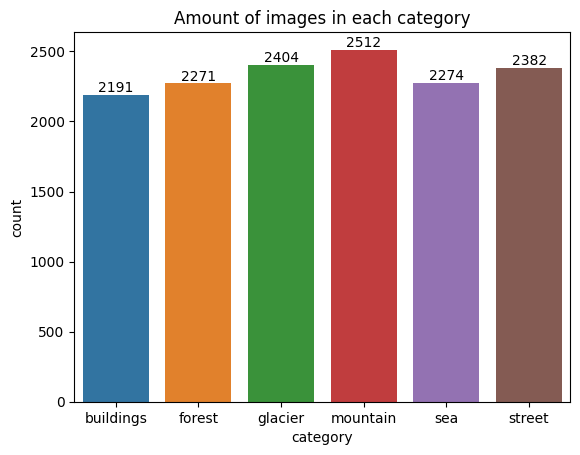

In [10]:
ax = sns.countplot(data=df_images_info, x='category')
ax.bar_label(ax.containers[0])
ax.set_title("Amount of images in each category")

As we can see, the dataset is pretty balanced.

To better understand the dataset, let's plot examples from each category.

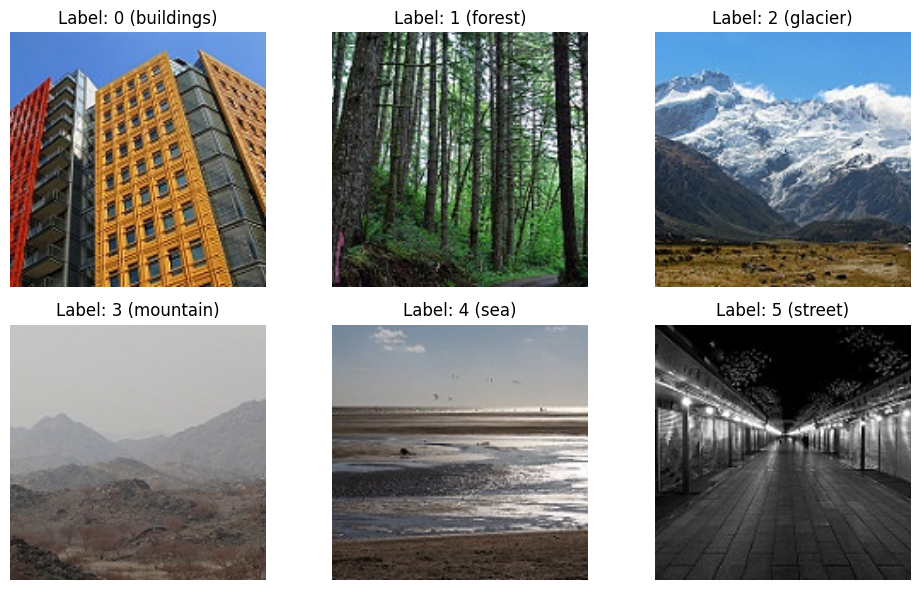

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

index = 0
for i in range(2):
    for j in range(3):

      label = df_images_info['label'][index]
      category = df_images_info['category'][index]
      file_path = os.path.join(root_dir, df_images_info.file_name[index])

      # read an image with OpenCV
      image = cv2.imread(file_path)

      # convert the image to RGB color space.
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # resize image
      image = cv2.resize(image, (256, 256))

      ax[i,j].imshow(image)
      ax[i,j].set_title(f"Label: {label} ({category})")
      ax[i,j].axis('off')
      # add to the index amount of images in category
      index += len(df_images_info[df_images_info['category'] == category])

plt.tight_layout()
plt.show()

## Step 2: prepare the model

Next, we set a baseline. As always, the first step is install and import of necessary libraries.

In [12]:
%%capture
!pip install timm

In [13]:
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

We define the "CustomDataset" class which is used to load and preprocess images from the provided dataset. "CustomDataset" inherits Dataset class from PyTorch.

In [14]:
class CustomDataset(Dataset):
    def __init__(self, df):

      self.root_dir = root_dir
      self.df = df
      self.file_names = df['file_name'].values
      self.labels = df['label'].values

      self.transform = A.Compose([A.Resize(image_size, image_size),
                                  ToTensorV2(),])

    def __len__(self):
      return len(self.df)

    def __getitem__(self, index): # Get sample from dataset

      label = self.labels[index]
      file_path = os.path.join(self.root_dir, self.file_names[index])

      # read an image with OpenCV
      image = cv2.imread(file_path)

      # convert the image to RGB color space.
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # apply transformation
      transformed = self.transform(image=image)
      image = transformed['image']

      # normalize because ToTensorV2() doesn't normalize the image
      image = image/255

      return image, label

Also we need define two other functions: for training one epoch and for validation one epoch.

In [20]:
def train_one_epoch(dataloader, model, optimizer, scheduler):
  # training mode
  model.train()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):

          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

          # optimize
          loss.backward()
          optimizer.step()

      scheduler.step()

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

In [21]:
def validate_one_epoch(dataloader, model):
  # validation mode
  model.eval()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      with torch.no_grad():
          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          # extend original list
          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

As we can see code for training and validation functions are similar. However, mixing them into a single function can make the code more complex and harder to understand. So it's better to keep them separate for better code organization and readability.

Now let's define function which fits the model for all epochs.

In [15]:
# fit model for all epochs
def fit(model, optimizer, scheduler, train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        acc, loss = train_one_epoch(train_dataloader, model, optimizer, scheduler)

        print(f'Train Loss: {loss:.4f} Train Accuracy: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader != None:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model)
            print(f'Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

Also we need function for visualisation the results (loss and accuracy).

In [16]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    list_for_plot = [acc, loss, val_acc, val_loss]

    for i in range(2):
      ax[i].plot(range(len(list_for_plot[i])), list_for_plot[i], label = 'train')
      ax[i].plot(range(len(list_for_plot[i+2])), list_for_plot[i+2], label = 'valid')
      ax[i].set_xticks(range(len(loss)), range(len(loss)))
      ax[i].set_xlabel('Epochs')
      ax[i].legend(loc="upper right")
    ax[0].set_title('Metric (Accuracy)')
    ax[1].set_title('Loss')
    plt.show()

Let's define settings of the training process.

In [17]:
image_size = 256
batch_size = 32

# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

n_classes = len(df_images_info.label.unique())
backbone = 'resnet18'

learning_rate = 1e-4

epochs = 5
lr_min = 1e-5

We use the cross-validation strategy for splitting dataset.

In [18]:
# Create a new column for cross-validation folds
df_images_info["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df_images_info, y = df_images_info.label)):
      df_images_info.loc[val_ , "kfold"] = fold

Let's choose model and run it for each fold of the cross-validation.

We use library with name "timm" to get pre-trained models.
As model, we use a ResNet with 18 layers. ResNet (Residual Network) is a type of convolutional neural network (CNN) using residual blocks.
There are many different models in the ResNet family. We will explore them in the step 3 and select the most suitable architecture for the task.

To train the model, we also need a loss function (criterion), an optimization algorithm (optimizer) and, a learning rate scheduler.

As loss function we will use categorical cross-entropy, which suit well for multi-class classification.

As optimizer, we will use algorithm Adam. Adam is a commonly used optimization algorithm.

We will use cosine decay as a learning rate scheduler for fine-tuning.

Epoch 1/5
Train Loss: 0.7894 Train Accuracy: 0.7883
Validation Loss: 0.2902 Validation Acc: 0.9049
Epoch 2/5
Train Loss: 0.2819 Train Accuracy: 0.9088
Validation Loss: 0.2285 Validation Acc: 0.9252
Epoch 3/5
Train Loss: 0.2270 Train Accuracy: 0.9242
Validation Loss: 0.2120 Validation Acc: 0.9291
Epoch 4/5
Train Loss: 0.1937 Train Accuracy: 0.9348
Validation Loss: 0.2050 Validation Acc: 0.9302
Epoch 5/5
Train Loss: 0.1810 Train Accuracy: 0.9390
Validation Loss: 0.2048 Validation Acc: 0.9305


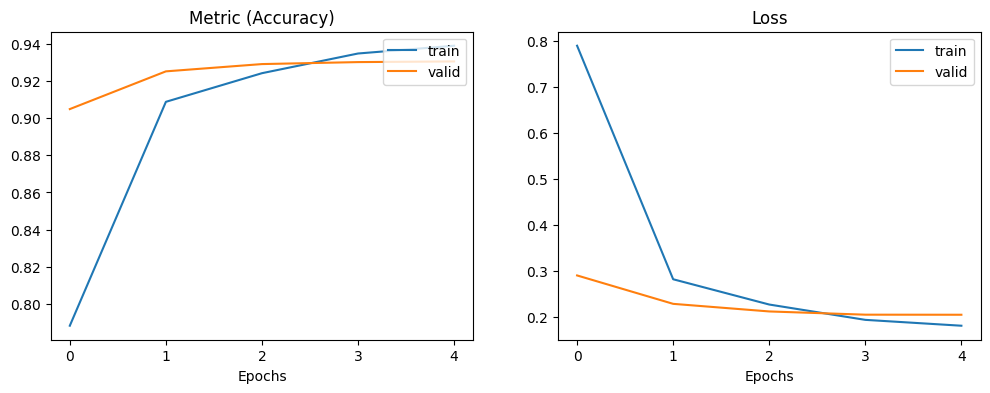

Epoch 1/5
Train Loss: 0.8158 Train Accuracy: 0.7759
Validation Loss: 0.2929 Validation Acc: 0.9124
Epoch 2/5
Train Loss: 0.2916 Train Accuracy: 0.9049
Validation Loss: 0.2209 Validation Acc: 0.9273
Epoch 3/5
Train Loss: 0.2264 Train Accuracy: 0.9250
Validation Loss: 0.2000 Validation Acc: 0.9305
Epoch 4/5
Train Loss: 0.1959 Train Accuracy: 0.9351
Validation Loss: 0.1917 Validation Acc: 0.9309
Epoch 5/5
Train Loss: 0.1795 Train Accuracy: 0.9398
Validation Loss: 0.1941 Validation Acc: 0.9316


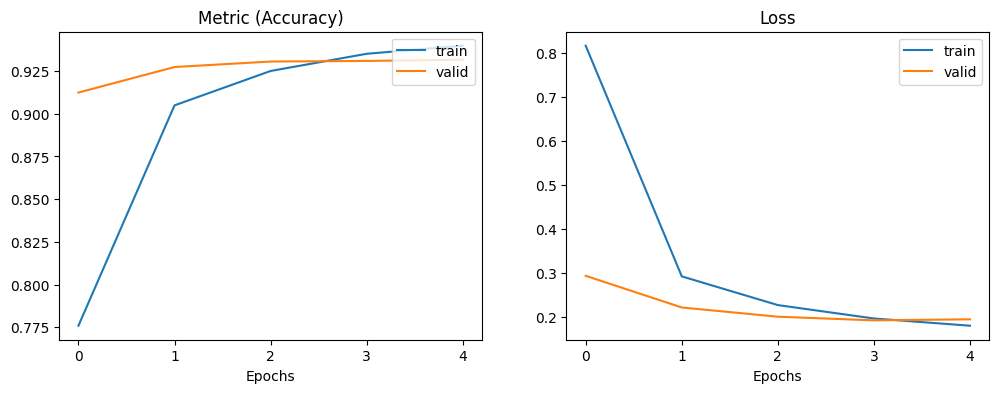

Epoch 1/5
Train Loss: 0.7745 Train Accuracy: 0.8007
Validation Loss: 0.2838 Validation Acc: 0.9113
Epoch 2/5
Train Loss: 0.2895 Train Accuracy: 0.9060
Validation Loss: 0.2103 Validation Acc: 0.9238
Epoch 3/5
Train Loss: 0.2243 Train Accuracy: 0.9272
Validation Loss: 0.2105 Validation Acc: 0.9230
Epoch 4/5
Train Loss: 0.1926 Train Accuracy: 0.9351
Validation Loss: 0.1919 Validation Acc: 0.9277
Epoch 5/5
Train Loss: 0.1827 Train Accuracy: 0.9419
Validation Loss: 0.1877 Validation Acc: 0.9295


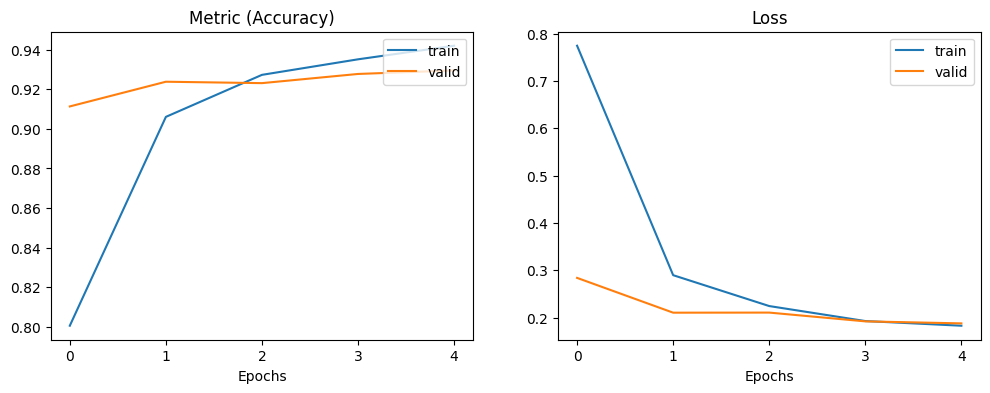

Epoch 1/5
Train Loss: 0.8243 Train Accuracy: 0.7560
Validation Loss: 0.2989 Validation Acc: 0.9031
Epoch 2/5
Train Loss: 0.2863 Train Accuracy: 0.9064
Validation Loss: 0.2286 Validation Acc: 0.9220
Epoch 3/5
Train Loss: 0.2255 Train Accuracy: 0.9241
Validation Loss: 0.2157 Validation Acc: 0.9270
Epoch 4/5
Train Loss: 0.1937 Train Accuracy: 0.9359
Validation Loss: 0.2046 Validation Acc: 0.9287
Epoch 5/5
Train Loss: 0.1787 Train Accuracy: 0.9434
Validation Loss: 0.2017 Validation Acc: 0.9270


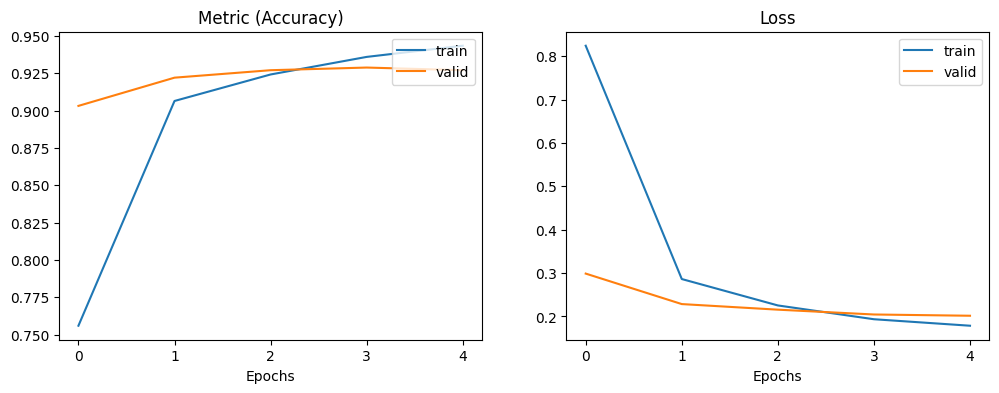

Epoch 1/5
Train Loss: 0.8307 Train Accuracy: 0.7753
Validation Loss: 0.3211 Validation Acc: 0.9038
Epoch 2/5
Train Loss: 0.2836 Train Accuracy: 0.9094
Validation Loss: 0.2329 Validation Acc: 0.9216
Epoch 3/5
Train Loss: 0.2225 Train Accuracy: 0.9281
Validation Loss: 0.2105 Validation Acc: 0.9266
Epoch 4/5
Train Loss: 0.1948 Train Accuracy: 0.9338
Validation Loss: 0.2039 Validation Acc: 0.9284
Epoch 5/5
Train Loss: 0.1726 Train Accuracy: 0.9422
Validation Loss: 0.2041 Validation Acc: 0.9287


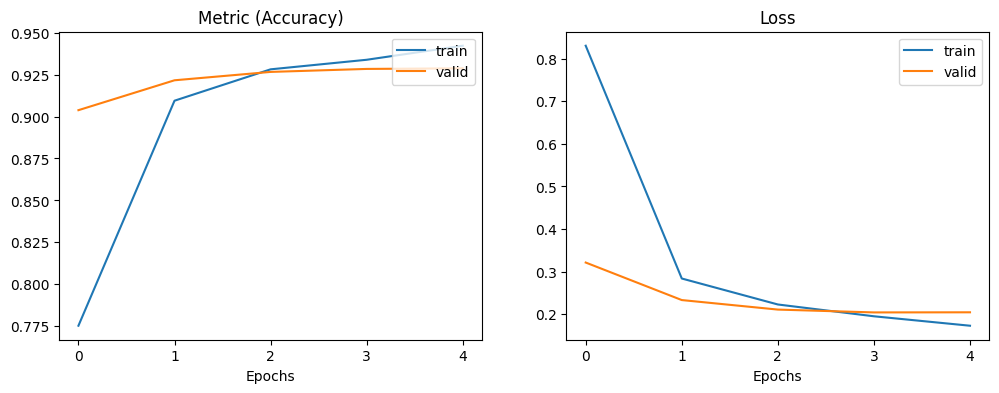

In [22]:
for fold in range(n_folds):
  train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
  valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

  train_dataset = CustomDataset(train_df)
  valid_dataset = CustomDataset(valid_df)

  train_dataloader = DataLoader(train_dataset,
                      batch_size = batch_size,
                      shuffle = True)
  valid_dataloader = DataLoader(valid_dataset,
                      batch_size = batch_size,
                      shuffle = False)


  model = timm.create_model(backbone,
                      pretrained = True,
                      num_classes = n_classes)

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()


  optimizer = torch.optim.Adam(model.parameters(),
                        lr = learning_rate,
                        weight_decay = 0,)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                         eta_min=lr_min)

  acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, train_dataloader, valid_dataloader)

  visualize_history(acc, loss, val_acc, val_loss)


## Step 3: run expirements